# Compare PIP of susie, DAP and CAVIAR

DAP and CAVIAR is performed on some of the same input data and is compared with `susie`.

In [1]:
%revisions -s

Revision,Author,Date,Message
a0a3c0b,Gao Wang,2018-05-31,Fix up PIP plot
d544c5d,Gao Wang,2018-05-31,Add caviar comparison plots
185fff8,Gao Wang,2018-05-29,Add ROC and PIP evaluations
61fd3cb,Gao Wang,2018-05-29,Plot computed PIP before / after LD filtering
ecc5b49,Gao Wang,2018-05-29,Update documentation
183fea4,Gao Wang,2018-05-29,Convert interactive exploration to pipeline
6ac6528,Gao Wang,2018-05-29,Add draft PIP comparison


## Plan

Here I consider the following scenarios:

- Fix total PVE to 0.2
- Scenario with growing difficulty: from 1 causal to 5 causal

For CAVIAR I only try and report 1~3 causal scenarios.

The plan is to get the PIP for those in susieR mappable CS (purity > 0.2 or 0.25), and compare these PIP to what DAP and CAVIAR reports. For susie flavors:

- use prior = 0.1 (may not matter)
- use estimate_residule = False (conservative)

This setting of susie should reflect its best performance. Additionally I check both the PIP computed before purity filter, and that after purity filter.

## Expected outcome

- PIP plots, 3-way: susie vs DAP, susie vs CAVIAR, DAP vs CAVIAR
- False discovery at set / cluster level
- A coarse ROC plot: report signals identified vs signal missed -- number of causal, under the same PVE setup.

Previously I've ran this specific DSC using:

```
dsc susie.dsc --target run_comparison -o susie_comparison
```

So here I query from that result.

## Workflow

In [18]:
[global]
cwd = path('~/GIT/github/mvarbvs/dsc')
dirname = path(f'{cwd:a}/susie_comparison/')
ld_col = 1
susie_prior = 0.1
#susie_prior = 0.05

In [18]:
[pip_1, fdr_1]
output: f'{dirname}/PIP_comparison_0528.rds'
R: expand = '${ }', workdir = cwd
    dap_out = dscrutils::dscquery(${dirname:br}, 
                        target = "liter_data.dataset lm_less lm_less.pve lm_less.n_signal fit_dap plot_dap",
                             load.pkl = TRUE)
    susie_out = dscrutils::dscquery(${dirname:br}, 
                        target = "liter_data.dataset lm_less lm_less.pve lm_less.n_signal fit_susie.prior_var fit_susie.estimate_residual_variance fit_susie plot_susie",
                             load.pkl = TRUE)
    caviar_out = dscrutils::dscquery(${dirname:br}, 
                        target = "liter_data.dataset lm_less lm_less.pve lm_less.n_signal fit_caviar.args fit_caviar plot_caviar",
                             load.pkl = TRUE)
    saveRDS(list(dap=dap_out, susie=susie_out, caviar=caviar_out), ${_output:r})

In [18]:
[pip_2]
pip_after_filter = ['FALSE', 'TRUE']
ld_cutoff = [0,0.2]
input: for_each = ['pip_after_filter', 'ld_cutoff'], concurrent = True
output: paths([f'{_input:n}.{x}_filter_{_pip_after_filter.lower()}_{str(_ld_cutoff).replace(".", "p")}.png' for x in ['susie_dap', 'susie_caviar', 'dap_caviar']])
R: stdout = f'{_output[0]:n}.log', expand = '${ }', workdir = cwd
    ld_col = ${ld_col}
    ld_cutoff = ${_ld_cutoff}
    pip_cutoff = 0
    dat = readRDS(${_input:r})
    dap_out = dat$dap
    caviar_out = dat$caviar
    susie_out = dat$susie
    # favorit susie flavor
    susie_out = susie_out[which(susie_out$fit_susie.prior_var == ${susie_prior} & susie_out$fit_susie.estimate_residual_variance == FALSE), ]
    susie_out = subset(susie_out, select =-c(lm_less.pve, fit_susie.prior_var, fit_susie.estimate_residual_variance))

    data_sets = unique(susie_out$liter_data.dataset)
    signals = unique(susie_out$lm_less.n_signal)

    result = list()
    for (s in signals) {
        result[[as.character(s)]] = NULL
        if (s > 3) {
            has_caviar = FALSE
        } else {
            has_caviar = TRUE
        }
        print(paste('==============', s, '=============='))
        for (d in data_sets) {
            out_files = susie_out[which(susie_out$lm_less.n_signal == s & susie_out$liter_data.dataset == d),c("fit_susie.output.file", "plot_susie.output.file", "lm_less.output.file")]
            fit = readRDS(paste0(${dirname:r}, '/', out_files[1,1], '.rds'))$posterior
            purity = readRDS(paste0(${dirname:r}, '/', out_files[1,2], '.rds'))
            truth = readRDS(paste0(${dirname:r}, '/', out_files[1,3], '.rds'))$data$true_coef
            signals = which(truth[,1]!=0)
            if (${_pip_after_filter}) {
              alpha = fit$alpha[[1]][which(purity$purity$V1[,ld_col] > ld_cutoff),,drop=FALSE]
            } else {
              alpha = fit$alpha[[1]]
            }
            pip = t(1 - apply(1 - alpha, 2, prod))
            in_CI = fit$in_CI[[1]]
            in_CI = in_CI[which(purity$purity$V1[,ld_col] > ld_cutoff),,drop=FALSE]
            in_CI = which(colSums(in_CI) > 0)
            pip = pip[in_CI]
            out_files = dap_out[which(dap_out$lm_less.n_signal == s & dap_out$liter_data.dataset == d),c("fit_dap.output.file"),drop=FALSE]
            dap = readRDS(paste0(${dirname:r}, '/', out_files[1,1], '.rds'))$posterior
            dap = dap$V0$snp
            #print(head(dap, length(pip)))
            dap = dap[which(dap$snp %in% as.character(in_CI)),]
            dap = dap[match(in_CI, dap$snp),]
            #print(dap)
            #print(pip)        
            #print(in_CI)
            if (has_caviar) {
                out_files = caviar_out[which(caviar_out$lm_less.n_signal == s & caviar_out$liter_data.dataset == d & caviar_out$fit_caviar.args == paste('-c', s)),c("fit_caviar.output.file"),drop=FALSE]
                caviar = readRDS(paste0(${dirname:r}, '/', out_files[1,1], '.rds'))$posterior
                caviar = caviar[[1]]$snp
                caviar = caviar[which(caviar$snp %in% as.character(in_CI)),]
                caviar = caviar[match(in_CI, caviar$snp),]
                pip = cbind(pip, as.vector(dap$snp_prob), as.vector(caviar$snp_prob), in_CI %in% signals)
            } else {
                pip = cbind(pip, as.vector(dap$snp_prob), in_CI %in% signals)
            }
            ## BEGIN debug
            outlier = pip[which(pip[,1] < 0.2 & pip[,2]>0.9), ,drop=F]
            if (nrow(outlier)>0 && s == 1) {
              print(d)
            }
            ## END debug  
            if (is.null(result[[as.character(s)]])) {
                result[[as.character(s)]] = pip
            } else {
                result[[as.character(s)]] = rbind(result[[as.character(s)]], pip)
            }
        }
        result[[as.character(s)]] = data.frame(result[[as.character(s)]])
        if (has_caviar) {
            colnames(result[[as.character(s)]]) = c('susie', 'dap', 'caviar', 'is_signal')
        } else {
            colnames(result[[as.character(s)]]) = c('susie', 'dap', 'is_signal')
        }
    }
    # susie vs dap
    png(${_output[0]:r}, 600, 800)
    #par(mar=c(.5,.5,.5,.5))
    par(mfrow=c(3, 2))
    for (i in 1:5) {
        i = as.character(i)
        x = result[[i]][result[[i]]$susie > pip_cutoff & result[[i]]$dap > pip_cutoff,]
        colors = sapply(1:length(x$is_signal), function(i) ifelse(x$is_signal[i],'#800000','#002b36'))
        plot(x$susie, x$dap, xlab = paste('PIP susie >', pip_cutoff), ylab = paste('PIP DAP >', pip_cutoff),
             main = paste('num. causal:', i, '\ncor:', round(cor(x)[1,2],2)),
            col = colors, pch = 20, cex = 1.5)
        abline(0,1,col=2)
        abline(h=0.95, col='gray')
        abline(v=0.95, col='gray')
    }
    dev.off()
    # susie vs caviar
    png(${_output[1]:r}, 600, 800)
    #par(mar=c(.5,.5,.5,.5))
    par(mfrow=c(2, 2))
    for (i in 1:3) {
        i = as.character(i)
        x = result[[i]][result[[i]]$susie > pip_cutoff & result[[i]]$caviar > pip_cutoff,]
        colors = sapply(1:length(x$is_signal), function(i) ifelse(x$is_signal[i],'#800000','#002b36'))
        plot(x$susie, x$caviar, xlab = paste('PIP susie >', pip_cutoff), ylab = paste('PIP CAVIAR >', pip_cutoff),
             main = paste('num. causal:', i, '\ncor:', round(cor(x)[1,2],2)),
            col = colors, pch = 20, cex = 1.5)
        abline(0,1,col=2)
        abline(h=0.95, col='gray')
        abline(v=0.95, col='gray')
    }
    dev.off()
    # dap vs caviar
    png(${_output[2]:r}, 600, 800)
    #par(mar=c(.5,.5,.5,.5))
    par(mfrow=c(2, 2))
    for (i in 1:3) {
        i = as.character(i)
        x = result[[i]][result[[i]]$dap > pip_cutoff & result[[i]]$caviar > pip_cutoff,]
        colors = sapply(1:length(x$is_signal), function(i) ifelse(x$is_signal[i],'#800000','#002b36'))
        plot(x$dap, x$caviar, xlab = paste('PIP DAP >', pip_cutoff), ylab = paste('PIP CAVIAR >', pip_cutoff),
             main = paste('num. causal:', i, '\ncor:', round(cor(x)[1,2],2)),
            col = colors, pch = 20, cex = 1.5)
        abline(0,1,col=2)
        abline(h=0.95, col='gray')
        abline(v=0.95, col='gray')
    }
    dev.off() 

In [23]:
[fdr_2]
# computer fdr
# to match with DAP -ld_control 0.25
ld_cutoff = 0.25
# to match with susie 95% mappable CS, we set dap cutoff to 0.95 also
dap_cluster_cutoff = [('cluster_prob', 0.95), ('cluster_avg_r2', 0.25)]
input: for_each = 'dap_cluster_cutoff', group_by = 1, concurrent = True
output: f'{dirname}/FDR_comparison_0528_{_dap_cluster_cutoff[0]}.rds'
R: stdout = f'{_output:n}.log', expand = '${ }', workdir = cwd
    ld_col = ${ld_col}
    ld_cutoff = ${ld_cutoff}
    dat = readRDS(${_input:r})
    dap_out = dat$dap
    susie_out = dat$susie
    # favorit susie flavor
    susie_out = susie_out[which(susie_out$fit_susie.prior_var == ${susie_prior} & susie_out$fit_susie.estimate_residual_variance == FALSE), ]
    susie_out = subset(susie_out, select =-c(lm_less.pve, fit_susie.prior_var, fit_susie.estimate_residual_variance))
    data_sets = unique(susie_out$liter_data.dataset)
    signals = unique(susie_out$lm_less.n_signal)
    result = NULL
    for (s in signals) {
        susie_tdc = 0
        dap_tdc = 0
        susie_dc = 0
        dap_dc = 0
        susie_tc = 0
        dap_tc = 0
        for (d in data_sets) {
            out_files = susie_out[which(susie_out$lm_less.n_signal == s & susie_out$liter_data.dataset == d), c("fit_susie.output.file", "plot_susie.output.file", "lm_less.output.file")]
            fit = readRDS(paste0(${dirname:r}, '/', out_files[1,1], '.rds'))$posterior
            purity = readRDS(paste0(${dirname:r}, '/', out_files[1,2], '.rds'))
            truth = readRDS(paste0(${dirname:r}, '/', out_files[1,3], '.rds'))$data$true_coef
            signals = which(truth[,1]!=0)
            # susie in CS
            susie_cs = fit$in_CI[[1]]
            susie_cs_raw = susie_cs[which(purity$purity$V1[,ld_col] > ld_cutoff),,drop=FALSE]
            susie_cs = list()
            if (nrow(susie_cs_raw) > 0) {
                for (i in 1:nrow(susie_cs_raw)) {
                  susie_cs[[i]] = which(susie_cs_raw[i,] > 0)
                  if (length(susie_cs[[i]]) == 0) {
                      susie_tc = susie_tc - 1
                      next
                  }
                  if (any(signals %in% susie_cs[[i]])) {
                      susie_tdc = susie_tdc + 1
                      susie_dc = susie_dc + 1
                  }
                }
            }
            print(paste('==============', s, '=============='))
            print(susie_cs)
            susie_tc = susie_tc + length(susie_cs)
            # DAP in cluster
            out_files = dap_out[which(dap_out$lm_less.n_signal == s & dap_out$liter_data.dataset == d),c("fit_dap.output.file"),drop=FALSE]
            dap = readRDS(paste0(${dirname:r}, '/', out_files[1,1], '.rds'))$posterior
            dap_cluster_raw = dap$V0$set[which(dap$V0$set$${_dap_cluster_cutoff[0]} > ${_dap_cluster_cutoff[1]}), ]$snp
            dap_cluster = list()
            if (length(dap_cluster_raw) > 0) {
                for (i in 1:length(dap_cluster_raw)) {
                  dap_cluster[[i]] = as.integer(unlist(strsplit(dap_cluster_raw[i], ",")))
                  if (any(signals %in% dap_cluster[[i]])) {
                      dap_tdc = dap_tdc + 1
                      dap_dc = dap_dc + 1
                  }
                }
            }
            print(dap_cluster)
            dap_tc = dap_tc + length(dap_cluster)
            ## BEGIN debug
            ## susie made more true discovery than DAP
            if (susie_dc > dap_dc) {
              print('DAP miss')
              print(dap$V0$set)
              print(d)
            }
            ## DAP made some (false) discovery, susie did not
            ## under n = 1
            if (length(dap_cluster) > dap_dc && s == 1) {
              print('DAP false discovery')
              print(dap$V0$set)
              print(d)  
            }
            ## END debug
            susie_dc = 0
            dap_dc = 0
        }
        rates = c(s, s* 50, susie_tc, dap_tc, susie_tdc/susie_tc, dap_tdc/dap_tc, 1 - (susie_tdc/susie_tc), 1 - (dap_tdc/dap_tc))
        if (is.null(result)) {
          result = rates
        } else {
          result = rbind(result, rates)
        }
    }
    colnames(result) = c('n_signal', 'expected_discoveries', 'susie_discoveries', 'dap_discoveries', 'susie_tdr', 'dap_tdr', 'susie_fdr', 'dap_fdr')
    rownames(result) = as.character(result[,1])
    saveRDS(data.frame(result), ${_output:r})

Workflow can only be executed with magic %run or %sosrun.

## PIP comparisons

### susie vs DAP

> /home/gaow/GIT/github/mvarbvs/dsc/susie_comparison/PIP_comparison_0528.susie_dap_filter_true_0.png (59.6 KiB):

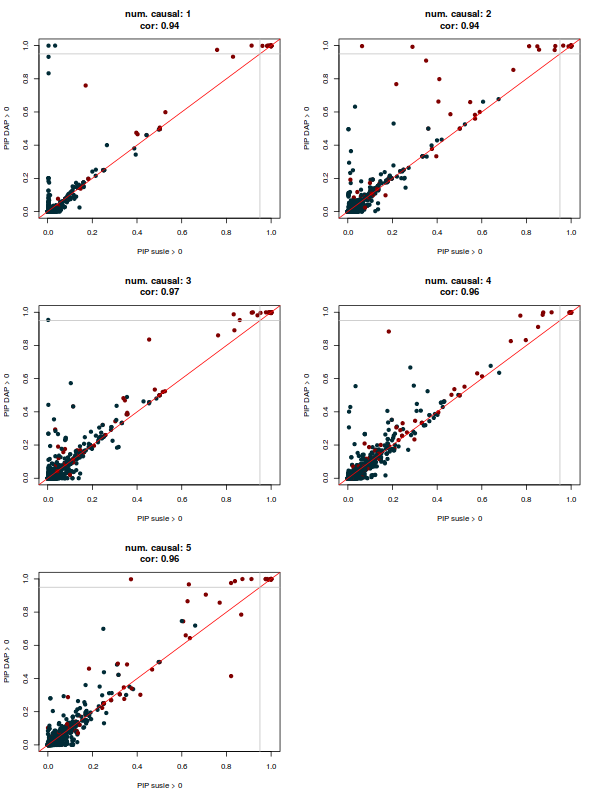

In [17]:
%preview ~/GIT/github/mvarbvs/dsc/susie_comparison/PIP_comparison_0528.susie_dap_filter_true_0.png

> /home/gaow/GIT/github/mvarbvs/dsc/susie_comparison/PIP_comparison_0528.susie_dap_filter_false_0.png (59.5 KiB):

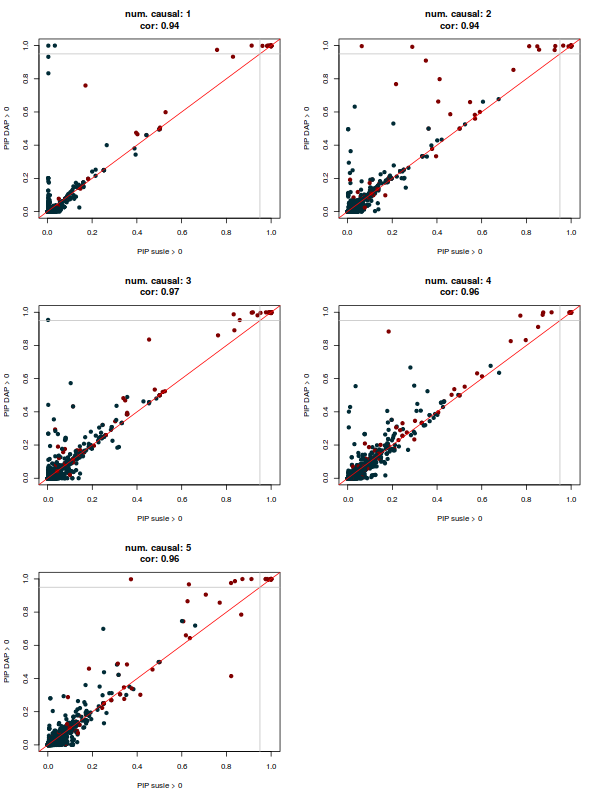

In [18]:
%preview ~/GIT/github/mvarbvs/dsc/susie_comparison/PIP_comparison_0528.susie_dap_filter_false_0.png

### susie vs CAVIAR

> /home/gaow/GIT/github/mvarbvs/dsc/susie_comparison/PIP_comparison_0528.susie_caviar_filter_true_0.png (51.2 KiB):

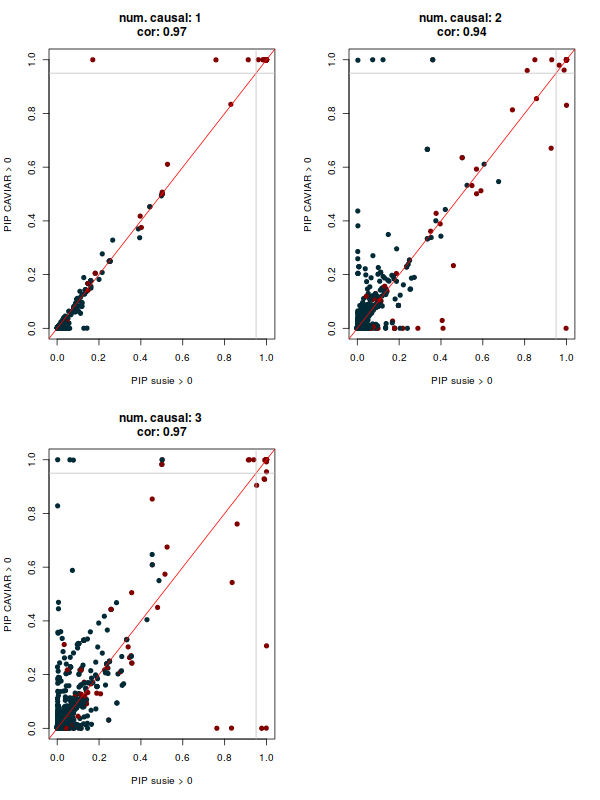

In [19]:
%preview ~/GIT/github/mvarbvs/dsc/susie_comparison/PIP_comparison_0528.susie_caviar_filter_true_0.png

### DAP vs CAVIAR

> /home/gaow/GIT/github/mvarbvs/dsc/susie_comparison/PIP_comparison_0528.dap_caviar_filter_true_0.png (51.0 KiB):

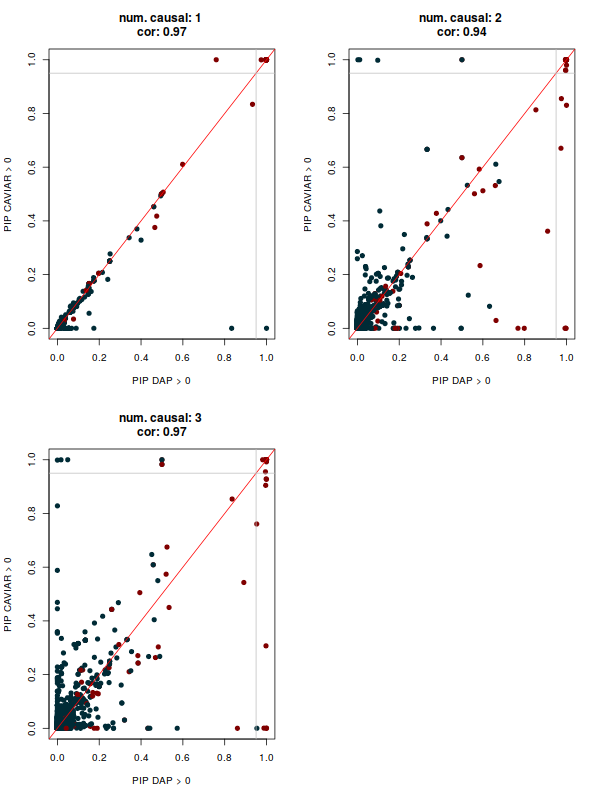

In [20]:
%preview ~/GIT/github/mvarbvs/dsc/susie_comparison/PIP_comparison_0528.dap_caviar_filter_true_0.png

## PIP outlier case

For susie vs DAP under 1-causal signal situation, there are some "outliers" for DAP -- high PIP that are not true signals, and correctly they have low PIP for susie. I document the simulation data-sets that resulted in such results:

```
[1] "~/Documents/GTExV8/Toys/Thyroid.ENSG00000031823.RDS"
[1] "~/Documents/GTExV8/Toys/Thyroid.ENSG00000124102.RDS"
[1] "~/Documents/GTExV8/Toys/Thyroid.ENSG00000135436.RDS"
```

**FIXME: to check these in detail why DAP reports false positives, under these scenarios**

## FDR comparison, susie vs DAP

DAP cluster is filtered by 95% cluster_prob

In [11]:
%cd ~/GIT/github/mvarbvs/dsc

/home/gaow/GIT/github/mvarbvs/dsc

In [26]:
readRDS('susie_comparison/FDR_comparison_0528_cluster_prob.rds')

n_signal,expected_discoveries,susie_discoveries,dap_discoveries,susie_tdr,dap_tdr,susie_fdr,dap_fdr
1,50,50,56,1.0000000,0.8571429,0.00000000,0.14285714
2,100,71,73,0.9436620,0.9315068,0.05633803,0.06849315
3,150,84,87,0.9761905,0.9425287,0.02380952,0.05747126
4,200,75,74,0.8800000,0.8648649,0.12000000,0.13513514
5,250,74,71,0.9594595,0.9014085,0.04054054,0.09859155


Now we check on cases that DAP did not behave well.

### Signals that susie captures but DAP misses, for n = 1 case

A typical case is that the set is large yet highly correlated, eg:

```
susie:
  [1] 335 531 532 533 536 538 539 540 541 542 543 544 546 547 548 549 550 551
 [19] 552 553 554 556 558 559 560 562 563 564 565 566 567 568 569 570 571 574
 [37] 575 576 577 578 579 581 585 586 587 588 591 592 593 594 597 598 601 602
 [55] 603 608 609 610 611 612 613 614 616 617 618 620 621 623 626 628 629 630
 [73] 633 634 635 639 641 642 645 646 647 648 650 651 652 653 654 655 656 657
 [91] 659 660 661 662 663 673 675 676 678 679 681 685 686 687 688 689 690 691
[109] 692 696 698 699 700 701 702 703 704 705 706 707 708 709 710 714 715 719
[127] 720 721 722 723 726 730 732 733 735 736 738 744 745 746

DAP:
list()
  cluster cluster_prob cluster_avg_r2
0       1     0.398200          0.992
1       2     0.006435          0.749
                                                                                                                                                                      snp
0 700,648,646,543,673,581,721,738,560,586,714,701,662,735,618,696,736,621,702,623,587,733,679,732,726,710,708,678,692,691,690,689,688,652,635,639,641,633,629,617,616,620
1                                                                                                                                                             152,361,515
[1] "~/Documents/GTExV8/Toys/Thyroid.ENSG00000083937.RDS"
```
So susie's CS is quite large. For the first cluster DAP comes up with, the avg r2 is high, and overlaps with susie CS, but the `cluster_prob` it computes is low. But indeed that cluster does contain the causal variable.

### DAP false discovery, for n = 1 case

Mostly I see are physically close signals falling in different DAP clusters, eg:

```
susie (and the truth)
[1] 765

DAP
[[1]]
[1] 765

[[2]]
[1] 786

  cluster cluster_prob cluster_avg_r2
0       1    0.9998000          1.000
1       2    0.9995000          1.000
...
[1] "~/Documents/GTExV8/Toys/Thyroid.ENSG00000031823.RDS"
```

and a more extreme case:

```
susie (and the truth)
[1] 669

DAP
[[1]]
[1] 669

[[2]]
 [1] 452 724 717 480 666 665 649 638 632 622 499 524 747 742 734 712 711 693 670
[20] 671 643 584 514 495 504 520 516 517 511 507 501 498 485 486 490 530 453

  cluster cluster_prob cluster_avg_r2
0       1    1.0000000          1.000
1       2    0.9973000          0.984
...
[1] "~/Documents/GTExV8/Toys/Thyroid.ENSG00000083937.RDS"
```

where the 2nd cluster has some variables (eg 665 and 666) very near the first cluster's only variable (669). But they ended up in a different cluster.